# RF with the QICK box

We will use the QICK box. Connect as follows:
* RF-out daughtercard in the 1st DAC slot (ports 4-7).
* Balun-out daughtercard in the 2nd DAC slot (ports 8-12).
* RF-in daughtercard in the 2nd ADC slot (ports 0-1). 
* Balun-in daughtercard in the 3rd ADC slot (ports 0-1). 
* DAC port 4 -> ADC port 5, with 40 dB attenuation
* DAC port 5 -> ADC port 4, with 40 dB attenuation
* DAC port 8 -> ADC port 6


In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from qick import *
from qick.rfboard import RFQickSoc216V1

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [2]:
# # crank up the logging (optional)
# import logging
# # logging.basicConfig(level=logging.DEBUG)
# logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

# # list(logging.root.manager.loggerDict.keys())
# # suppress the start/stop messages from the tproc logger
# logging.getLogger('qick_processor').setLevel(logging.WARNING)

In [3]:
# Load bitstream with custom overlay
soc = RFQickSoc216V1('fw/2025-08-15_216_tprocv2r26_rfbv2_standard/qick_216_rfbv2.bit')

soccfg = soc

# print(soccfg)

In [4]:
print(soccfg)

QICK running on ZCU216, software version 0.2.363

Firmware configuration (built Sat Aug 16 12:14:08 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 1, ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228 on JHC1, or QICK box DAC port 0
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228 on JHC2, or QICK box DAC port 1
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 32768 complex samples (3.419 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228 on JHC1, or QICK box DAC port 2
	3:	axis_signal_ge

In [5]:
# firmware channel numbers for generators and readouts
GEN_CH_RF = 5
GEN_CH_BALUN = 8
GEN_CH_MUX = 4

RO_CH_RF = 0
RO_CH_BALUN = 1
RO_CHS_MUX = [2, 3, 4, 5, 6, 7, 8, 9]

# physical DAC and ADC ports
DAC_RF = 5
DAC_BALUN = 8
DAC_MUX = 4
ADC_RF = 4
ADC_BALUN = 6
ADC_MUX = 5

# RF daughtercard attenuations, dB (0 through 31.75)
DAC_ATT = [0, 10]
ADC_ATT = 25

## Readout
Let's experiment with phase-coherent readout.

First, let's run the readout with downconversion bypassed, and run the buffer in "decimated" mode where it saves the sample-by-sample contents of the readout window.

  0%|          | 0/1 [00:00<?, ?it/s]

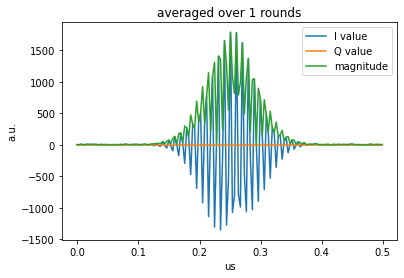

In [6]:
class ReadoutProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']

        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=0)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch,
                              phase=cfg['ro_phase'],
                              outsel=cfg['ro_outsel'],
                              )

        self.add_gauss(ch=gen_ch, name="gausenv", sigma=cfg['pulse_len']/10, length=cfg['pulse_len'], even_length=True)
        
        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gausenv", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        # trigger the MR buffer a little later so it starts recording after the pulse starts
        self.trigger(ddr4=True, mr=True, t=cfg['trig_time']+0.5)

config = {
          'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'nqz': 1,
          'trig_time': 0.4,
          'ro_len': 0.5,
          'pulse_len': 0.4,
          'gain': 0.1,
          'ro_phase': 0,
          # 'ro_outsel': 'product'
          'ro_outsel': 'input'
         }

prog = ReadoutProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=1)
t = prog.get_time_axis(ro_index=0)


iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.title("averaged over %d rounds" % (len(prog.get_rounds())))
plt.ylabel("a.u.")
plt.xlabel("us");

Without downconversion, the pulse phase shifts across the readout window and shots do not add coherently: if we average over multiple acquisitions, the amplitude goes down.

  0%|          | 0/100 [00:00<?, ?it/s]

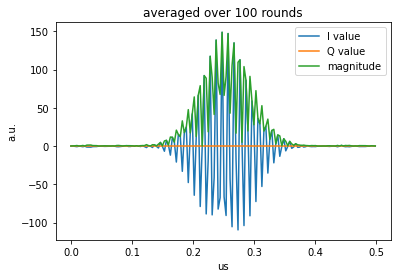

In [7]:
prog = ReadoutProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=100)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.title("averaged over %d rounds" % (len(prog.get_rounds())))
plt.ylabel("a.u.")
plt.xlabel("us");

With downconversion, we get back the original Gaussian envelope, and the signal adds coherently - however, we see that there's an arbitrary phase offset between the generator and readout.

  0%|          | 0/1 [00:00<?, ?it/s]

measured phase -141.615381 degrees


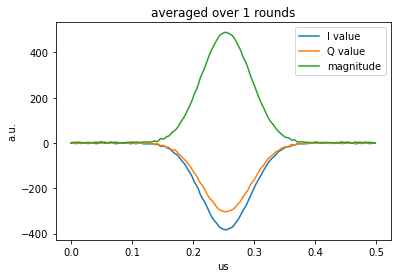

In [8]:
config['ro_outsel'] = 'product'
prog = ReadoutProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=1)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.title("averaged over %d rounds" % (len(prog.get_rounds())))
plt.ylabel("a.u.")
plt.xlabel("us");

phase_offset = np.angle(iq.dot([1,1j]).sum(), deg=True)
print("measured phase %f degrees"%(phase_offset))

We can subtract out the phase offset in either the generator or the readout, to put the signal back on the real axis - let's do it at the readout.


  0%|          | 0/1 [00:00<?, ?it/s]

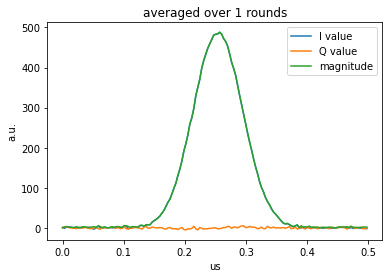

In [9]:
config['ro_phase'] = -phase_offset
prog = ReadoutProgram(soccfg, reps=1, final_delay=1.0, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=1)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.title("averaged over %d rounds" % (len(prog.get_rounds())))
plt.ylabel("a.u.")
plt.xlabel("us");

# phase = np.angle(iq.dot([1,1j]).sum(), deg=True)
# print("measured phase %f degrees"%(phase))

Decimated readout is normally only useful for debugging; for high-statistics measurements we use the "accumulated" mode where the buffer only saves the sum of the samples in the window. acquire() returns the average of the shots, normalized by the window length; get_raw() lets you look at the raw, unnormalized shot-by-shot data.

  0%|          | 0/100000 [00:00<?, ?it/s]

Text(0, 0.5, 'Q value')

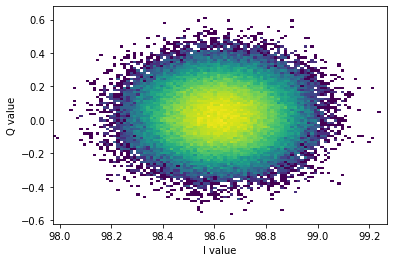

In [10]:
soc.freeze_adc_cals([soccfg['readouts'][RO_CH_BALUN]['adc']])
prog = ReadoutProgram(soccfg, reps=100000, final_delay=1.0, cfg=config)
iq_list = prog.acquire(soc)
nsamp = float(len(prog.get_time_axis(ro_index=0)))

iq = iq_list[0][0]
iq_shots = prog.get_raw()[0][:,0]/nsamp

from matplotlib import colors
center = iq
span = 100/nsamp
hrange = [[center[0]-span, center[0]+span],[center[1]-span, center[1]+span]]
plt.hist2d(iq_shots[:,0], iq_shots[:,1], bins=100, range=hrange, norm=colors.LogNorm());
plt.xlabel("I value")
plt.ylabel("Q value")

## Loops and sweeps
Using the same channels as the previous section, let's first do a silly sweep where we change the pulse gain and phase simultaenously.

In [11]:
class SimpleSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch,
                              phase=cfg['ro_phase'],
                              )

        self.add_loop("myloop", self.cfg["steps"])

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

  0%|          | 0/10 [00:00<?, ?it/s]

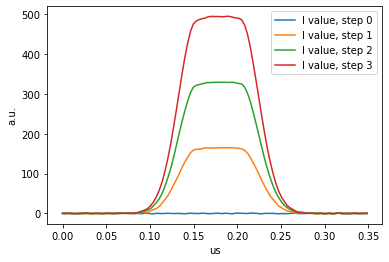

In [12]:
# do a sweep with 4 points and plot decimated
config = {'steps': 4,
          'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'trig_time': 0.4,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("myloop", -360, 720),
          'gain': QickSweep1D("myloop", 0.0, 1.0),
          'ro_phase': -phase_offset,
         }

prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, rounds=10)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

  0%|          | 0/20100 [00:00<?, ?it/s]

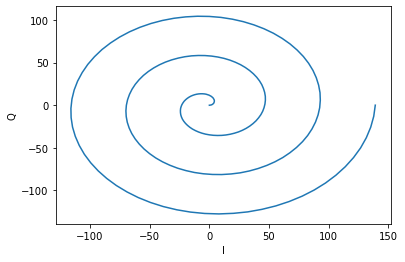

In [13]:
# do a higher-res sweep with acquire()
config['steps']=201
prog = SimpleSweepProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
iq_list = prog.acquire(soc, rounds=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1])
plt.ylabel("Q")
plt.xlabel("I");

Note that you don't need to do anything special in your program to sweep a parameter - all pulse parameters can be numbers or sweeps, it should just work.

  0%|          | 0/10 [00:00<?, ?it/s]

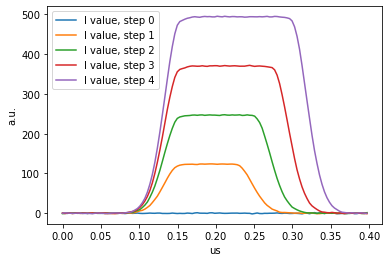

In [14]:
# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'trig_time': 0.4,
          'ro_len': 0.4,
          'flat_len': QickSweep1D("myloop", 0.05, 0.15),
          'ramp_len': 0.2,
          'phase': 0,
          'gain': QickSweep1D("myloop", 0.0, 1.0),
          'ro_phase': -phase_offset,
         }

prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, rounds=10)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

Delays and times can also be swept.

  0%|          | 0/10 [00:00<?, ?it/s]

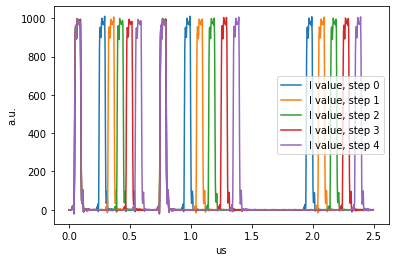

In [15]:
class DelaySweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch,
                              phase=cfg['ro_phase'],
                              )

        self.add_loop("myloop", self.cfg["steps"])

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=QickSweep1D("myloop", 0.2, 0.5))
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.7)
        
        self.delay(QickSweep1D("myloop", 0.9, 1.3))
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=1.0)

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'trig_time': 0.4,
          'ro_len': 2.5,
          'pulse_len': 0.05,
          'phase': 0,
          'gain': 1.0,
          'ro_phase': -phase_offset,
         }

prog = DelaySweepProgram(soccfg, reps=1, final_delay=1.0, cfg=config)

iq_list = prog.acquire_decimated(soc, rounds=10)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

Let's try a 2D scan of gain and phase.

  0%|          | 0/500000 [00:00<?, ?it/s]

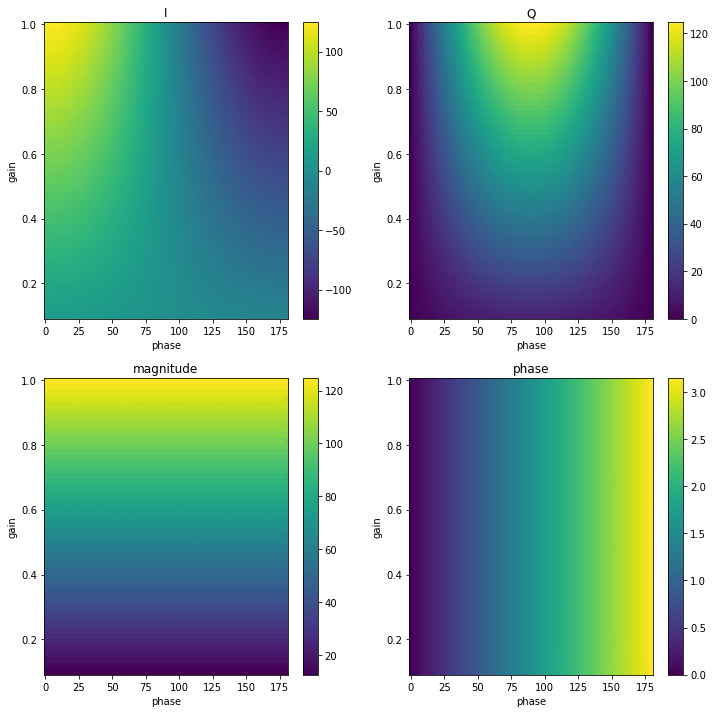

In [16]:
class Sweep2DProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch,
                              phase=cfg['ro_phase'],
                              )

        self.add_loop("loop1", self.cfg["steps1"]) # this will be the outer loop
        self.add_loop("loop2", self.cfg["steps2"]) # this will be the inner loop

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.delay(0.5) # give the tProc some time for initial setup
        self.trigger(ddr4=True, mr=True, t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

config = {'steps1': 50,
          'steps2': 100,
          'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'trig_time': 0.4,
          'ro_len': 0.4,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("loop2", 0, 180),
          'gain': QickSweep1D("loop1", 0.1, 1.0),
          'ro_phase': -phase_offset,
         }

prog = Sweep2DProgram(soccfg, reps=100, final_delay=1.0, cfg=config)

iq_list = prog.acquire(soc)

fig, axes = plt.subplots(2, 2, figsize=(12,12))

# get the exact values of the parameters, after rounding - this also works for scalars (without as_array), you will just get a float
phases = prog.get_pulse_param("mypulse", "phase", as_array=True)
gains = prog.get_pulse_param("mypulse", "gain", as_array=True)

plot = axes[0,0]
plt.colorbar(plot.pcolormesh(phases, gains, iq_list[0][0,:,:,0]), ax=plot)
plot.set_title("I")
plot.set_ylabel("gain")
plot.set_xlabel("phase")
plot = axes[0,1]
plt.colorbar(plot.pcolormesh(phases, gains, iq_list[0][0,:,:,1]), ax=plot)
plot.set_title("Q")
plot.set_ylabel("gain")
plot.set_xlabel("phase")

plot = axes[1,0]
plt.colorbar(plot.pcolormesh(phases, gains, np.abs(iq_list[0][0].dot([1,1j]))), ax=plot)
plot.set_title("magnitude")
plot.set_ylabel("gain")
plot.set_xlabel("phase")

plot = axes[1,1]
plt.colorbar(plot.pcolormesh(phases, gains, np.unwrap(np.angle(iq_list[0][0].dot([1,1j])), axis=1)), ax=plot)
plot.set_title("phase")
plot.set_ylabel("gain")
plot.set_xlabel("phase");

We can take a look at the loop structure with the DDR4 buffer, which can do very long captures.

  0%|          | 0/150 [00:00<?, ?it/s]

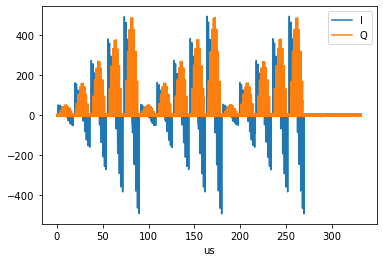

In [18]:
config = {'steps1': 5,
          'steps2': 10,
          'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'trig_time': 0.4,
          'ro_len': 0.4,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("loop2", 0, 180),
          'gain': QickSweep1D("loop1", 0.1, 1.0),
          'ro_phase': -phase_offset,
         }

prog = Sweep2DProgram(soccfg, reps=3, final_delay=1.0, cfg=config)

n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
# Arm the buffers
soc.arm_ddr4(ch=config['ro_ch'], nt=n_transfers)
soc.arm_mr(ch=config['ro_ch'])

prog.run_rounds(soc)

# now you see the loop order: innermost loop of 10 phase steps, mid loop of 5 gain steps, outer loop of 3 identical reps
iq_ddr4 = soc.get_ddr4(800)
t = prog.get_time_axis_ddr4(config['ro_ch'], iq_ddr4)

plt.plot(t, iq_ddr4[:,0],label="I")
plt.plot(t, iq_ddr4[:,1],label="Q")
# plt.plot(np.abs(iq_ddr4.dot([1,1j])),label="mag")
plt.xlabel("us")
plt.legend();

## Complex pulse sequences
Here's a dumb pulse sequence that includes a virtual-Z gate: [X/2, Y/2, X/2, Y/2, Z, X/2, Y/2, X/2, Y/2].

We can do this by pre-evaluating the virtual Z and writing the program in a fixed reference frame:

  0%|          | 0/1 [00:00<?, ?it/s]

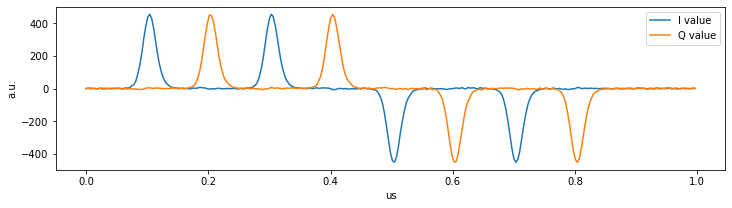

In [19]:
from qick.asm_v2 import AsmV2
class PulseSequenceProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
                # we can use the same config for the two readouts
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch, phase=cfg['ro_phase'])


        pulse_len = cfg['pulse_len']
        self.add_gauss(ch=gen_ch, name="gauss", sigma=pulse_len/10, length=pulse_len, even_length=False)
        
        self.add_pulse(ch=gen_ch, name="x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=90,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="-x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=180,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="-y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=270,
                       gain=1.0, 
                      )

        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
    
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.pulse(ch=cfg['gen_ch'], name="x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="y/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="y/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-y/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-x/2", t=0)
        self.delay(cfg['pulse_len'])
        self.pulse(ch=cfg['gen_ch'], name="-y/2", t=0)
        self.delay(cfg['pulse_len'])
        
        
config = {'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'trig_time': 0.4,
          'ro_len': 1.0,
          'pulse_len': 0.1,
          'ro_phase': -phase_offset,
         }

prog = PulseSequenceProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc)
t = prog.get_time_axis(ro_index=0)

fig = plt.figure(figsize=(12,3))

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

Or we could have the virtual-Z gate be a subroutine that updates the pulse definitions. This would more generally allow you to define more complicated gates in your gate set.

  0%|          | 0/1 [00:00<?, ?it/s]

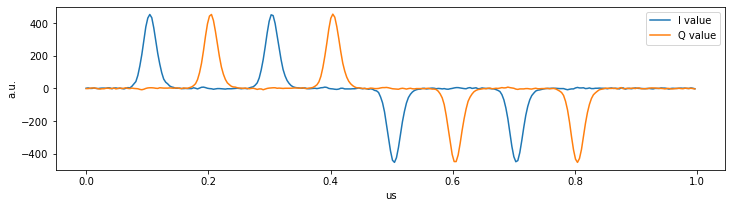

In [20]:
from qick.asm_v2 import AsmV2
class PulseUpdateProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch, phase=cfg['ro_phase'])


        pulse_len = cfg['pulse_len']
        self.add_gauss(ch=gen_ch, name="gauss", sigma=pulse_len/10, length=pulse_len)
        
        self.add_pulse(ch=gen_ch, name="x/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        self.add_pulse(ch=gen_ch, name="y/2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=90,
                       gain=1.0, 
                      )

        sub = AsmV2()
        sub.pulse(ch=cfg['gen_ch'], name="x/2", t=0)
        sub.delay(pulse_len)
        self.add_subroutine("play_x/2", sub)

        sub = AsmV2()
        sub.pulse(ch=cfg['gen_ch'], name="y/2", t=0)
        sub.delay(pulse_len)
        self.add_subroutine("play_y/2", sub)

        sub = AsmV2()
        for wname in self.list_pulse_waveforms("x/2")+self.list_pulse_waveforms("y/2"):
            sub.read_wmem(name=wname)
            sub.inc_reg(dst='w_phase', src=self.deg2reg(180, gen_ch=cfg['gen_ch']))
            sub.write_wmem(name=wname)
        self.add_subroutine("virt_z", sub)

        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
    
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.call("play_x/2")
        self.call("play_y/2")
        self.call("play_x/2")
        self.call("play_y/2")
        self.call("virt_z")
        self.call("play_x/2")
        self.call("play_y/2")
        self.call("play_x/2")
        self.call("play_y/2")

        # reset the phase to 0
        for wname in self.list_pulse_waveforms("x/2"):
            self.read_wmem(name=wname)
            self.write_reg(dst='w_phase', src=0)
            self.write_wmem(name=wname)
        for wname in self.list_pulse_waveforms("y/2"):
            self.read_wmem(name=wname)
            self.write_reg(dst='w_phase', src=self.deg2reg(90, gen_ch=cfg['gen_ch']))
            self.write_wmem(name=wname)
        
config = {'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'freq': 100,
          'trig_time': 0.4,
          'ro_len': 1.0,
          'pulse_len': 0.1,
          'ro_phase': -phase_offset,
         }

prog = PulseUpdateProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc)
t = prog.get_time_axis(ro_index=0)

fig = plt.figure(figsize=(12,3))

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

## QICK box RF daughtercards

The RF-out and RF-in daughtercards have chains of amplifiers and digitally controlled attenuators that are optimized to drive signals in and out of a fridge with no additional warm amplification.

Both daughetercards also have digitally controlled RF filters. These are used to remove spurious Nyquist images on the DAC side, and Nyquist-folded noise on the ADC side.

In [21]:
print("set DAC attenuators:", soc.rfb_set_dac_rf(DAC_RF, *DAC_ATT))
print("set ADC attenuators:", soc.rfb_set_adc_rf(ADC_RF, ADC_ATT))
soc.rfb_set_dac_filter(DAC_RF, fc=6.0, ftype='bandpass', bw=1.0)
soc.rfb_set_adc_filter(ADC_RF, fc=6.0, ftype='bandpass', bw=1.0)

set DAC attenuators: (0.0, 10.0)
set ADC attenuators: 25.0


  0%|          | 0/10 [00:00<?, ?it/s]

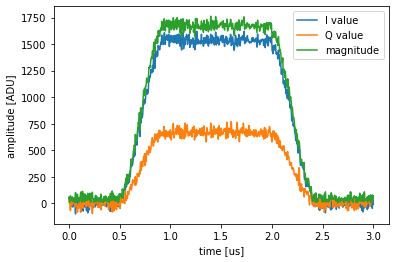

In [22]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
#                        style="const",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], t=cfg['trig_time'])

config = {'gen_ch': GEN_CH_RF,
          'ro_ch': RO_CH_RF,
          'mixer_freq': 6000,
          'freq': 6000,
          'nqz': 2,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']
soc.rfb_set_dac_filter(DAC_RF, fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_adc_filter(ADC_RF, fc=freq/1000, ftype='bandpass', bw=1.0)

iq_list = prog.acquire_decimated(soc, rounds=10)

t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot((1,1j))), label="magnitude")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

  0%|          | 0/1 [00:00<?, ?it/s]

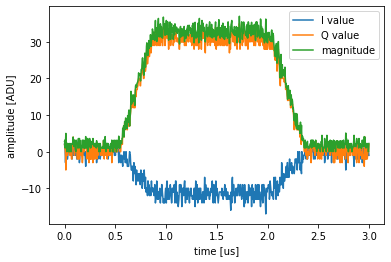

In [23]:
config = {'gen_ch': GEN_CH_BALUN,
          'ro_ch': RO_CH_BALUN,
          'mixer_freq': 6000,
          'freq': 6000,
          'nqz': 2,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, rounds=1)

t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot((1,1j))), label="magnitude")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

### testing the filters

Let's play with the filters; for simplicity, we'll always configure the RF-out and RF-in filters identically.

In [24]:
class FreqSweepProgram(AveragerProgramV2): # for int gen and dyn RO
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


# int gen frequency range is limited, so stitch ranges together
def measure_s21(gen_ch, ro_ch, nqz, gain, steps=101, dds_range=0.45, overlap=0, plot=False, progress=True):
    soc.clear_interrupts()
    config = {'steps': steps,
              'gen_ch': gen_ch,
              'ro_ch': ro_ch,
              'nqz': nqz,
              'trig_time': 0.4,
              'pulse_len': 10.0,
              'ro_len': 10.1,
              'phase': 0,
              'gain': gain
             }
    allfreqs = []
    allpowers = []
    f_dds = soccfg['gens'][gen_ch]['f_dds']
    mixer_freqs = np.arange(0.5, 10000/f_dds, dds_range*2-overlap)*f_dds    
    for i, mixer_freq in enumerate(tqdm(mixer_freqs, disable=not progress)):
        config['mixer_freq'] = mixer_freq
        config['freq'] = QickSweep1D("myloop", mixer_freq-dds_range*f_dds, mixer_freq+dds_range*f_dds)

        prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
        freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
        iq_list = prog.acquire(soc, rounds=1, progress=False)

        iq_complex = iq_list[0][0].dot([1,1j])
        mags = np.abs(iq_complex)
        powers = 20*np.log10(mags)
        allfreqs.append(freqs)
        allpowers.append(powers)
        if plot:
            plt.plot(freqs, powers, label="mixer_freq=%f"%(mixer_freq))
        #     plt.plot(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
            plt.ylabel("S21 [arb. dB]")
            plt.xlabel("Frequency [MHz]")
    allfreqs = np.array(allfreqs).flatten()
    allpowers = np.array(allpowers).flatten()
    return allfreqs, allpowers

def set_filter(lpf, hpf, filt=0):
    sw = 0xc0 + (hpf<<3) + lpf
    filt_bits = (filt<<4) + filt
    rfb_ch = soc.adc_chains[ADC_RF]
    with soc.board_sel.enable_context(rfb_ch.card_num):
        rfb_ch.filter.write_reg('WR0_SW', sw)
        rfb_ch.filter.write_reg('WR0_FILTER', filt_bits)
    rfb_ch = soc.dac_chains[DAC_RF]
    with soc.board_sel.enable_context(rfb_ch.card_num):
        rfb_ch.filter.write_reg('WR0_SW', sw)
        rfb_ch.filter.write_reg('WR0_FILTER', filt_bits)

With the filters in bypass mode, we need to crank up all of the attenuators to avoid saturating the signal chain.

set DAC attenuators: (30.0, 30.0)
set ADC attenuators: 30.0


  0%|          | 0/7 [00:00<?, ?it/s]

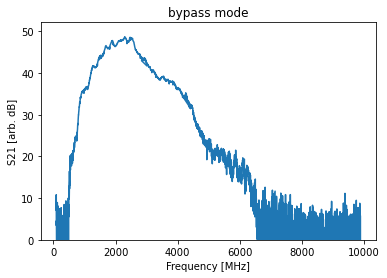

In [25]:
print("set DAC attenuators:", soc.rfb_set_dac_rf(DAC_RF, 30, 30))
print("set ADC attenuators:", soc.rfb_set_adc_rf(ADC_RF, 30))
soc.rfb_set_rfadc_attenuator(ADC_RF, 10)
soc.rfb_set_dac_filter(DAC_RF, fc=0, ftype='bypass')
soc.rfb_set_adc_filter(ADC_RF, fc=0, ftype='bypass')

plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,nqz=2,gain=1.0,steps=501,dds_range=0.45,overlap=0.1));
# soc.rfb_set_rfadc_attenuator(ADC_RF, 0)

plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("bypass mode");


Let's work our way through the filters - each ADMV8818 filter has four selectable "bands" of low-pass and high-pass filters, each of which can be tuned through 16 "states."

set DAC attenuators: (30.0, 30.0)
set ADC attenuators: 30.0


  0%|          | 0/5 [00:00<?, ?it/s]

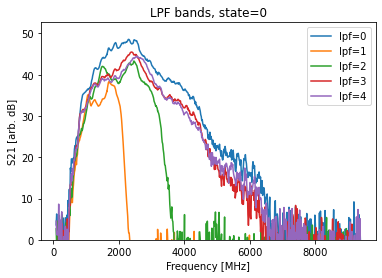

In [26]:
print("set DAC attenuators:", soc.rfb_set_dac_rf(DAC_RF, 30, 30))
print("set ADC attenuators:", soc.rfb_set_adc_rf(ADC_RF, 30))
soc.rfb_set_rfadc_attenuator(ADC_RF, 10)
soc.rfb_set_dac_filter(DAC_RF, fc=0, ftype='bypass')
soc.rfb_set_adc_filter(ADC_RF, fc=0, ftype='bypass')

for lpf in tqdm(range(0,5)):
    set_filter(lpf, 0, 0)

    plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,2,1.0, progress=False), label="lpf=%d"%(lpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF bands, state=0")
plt.legend();

  0%|          | 0/16 [00:00<?, ?it/s]

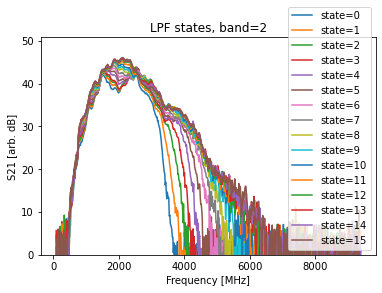

In [27]:
for state in tqdm(range(0,16)):
    set_filter(2, 0, state)

    plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF states, band=2")
plt.legend();

  0%|          | 0/5 [00:00<?, ?it/s]

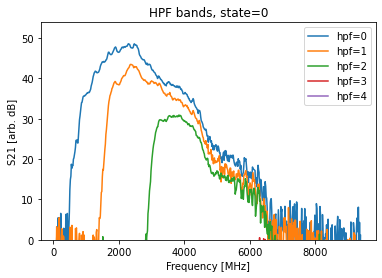

In [28]:
for hpf in tqdm(range(0,5)):
    set_filter(0, hpf, 0)

    plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,2,1.0, progress=False), label="hpf=%d"%(hpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF bands, state=0")
plt.legend();

  0%|          | 0/16 [00:00<?, ?it/s]

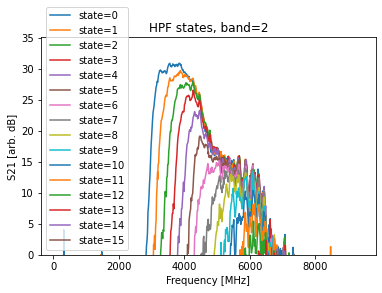

In [29]:
for state in tqdm(range(0,16)):
    set_filter(0, 2, state)

    plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF states, band=2")
plt.legend();

You can put these filters together to get a bandpass response at your frequency of interest.

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

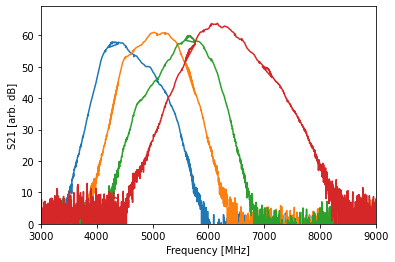

In [30]:
soc.rfb_set_dac_filter(DAC_RF, fc=5, ftype='bandpass', bw=1.0)
soc.rfb_set_adc_filter(ADC_RF, fc=5, ftype='bandpass', bw=1.0)
soc.rfb_set_dac_rf(DAC_RF, 0, 30)
soc.rfb_set_adc_rf(ADC_RF, 30)
soc.rfb_set_rfadc_attenuator(ADC_RF, 0)
plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,nqz=2,gain=1.0,steps=501,dds_range=0.45,overlap=0.1));

soc.rfb_set_dac_filter(DAC_RF, fc=5.5, ftype='bandpass', bw=0.5)
soc.rfb_set_adc_filter(ADC_RF, fc=5.5, ftype='bandpass', bw=0.5)
soc.rfb_set_dac_rf(DAC_RF, 0, 20)
soc.rfb_set_adc_rf(ADC_RF, 25)
plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,nqz=2,gain=1.0,steps=501,dds_range=0.45,overlap=0.1));

soc.rfb_set_dac_filter(DAC_RF, fc=6, ftype='bandpass', bw=0.5)
soc.rfb_set_adc_filter(ADC_RF, fc=6, ftype='bandpass', bw=0.5)
soc.rfb_set_dac_rf(DAC_RF, 0, 20)
soc.rfb_set_adc_rf(ADC_RF, 25)
plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,nqz=2,gain=1.0,steps=501,dds_range=0.45,overlap=0.1));

soc.rfb_set_dac_filter(DAC_RF, fc=7, ftype='bandpass', bw=1.0)
soc.rfb_set_adc_filter(ADC_RF, fc=7, ftype='bandpass', bw=1.0)
soc.rfb_set_dac_rf(DAC_RF, 0, 15)
soc.rfb_set_adc_rf(ADC_RF, 20)
plt.plot(*measure_s21(GEN_CH_RF,RO_CH_RF,nqz=2,gain=1.0,steps=501,dds_range=0.45,overlap=0.1));

soc.rfb_set_dac_rf(DAC_RF, 30, 30)
soc.rfb_set_adc_rf(ADC_RF, 30)

plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.xlim((3000, 9000));

## Multiplexed generator and readout

We connect the multiplexed generator to the multiplexed readout (DAC port 4 to ADC port 5), and configure the daughtercard channels.

In [31]:
print("set DAC attenuators:", soc.rfb_set_dac_rf(DAC_MUX, *DAC_ATT))
print("set ADC attenuators:", soc.rfb_set_adc_rf(ADC_MUX, ADC_ATT))
soc.rfb_set_dac_filter(DAC_MUX, fc=6.0, ftype='bandpass', bw=1.0)
soc.rfb_set_adc_filter(ADC_MUX, fc=6.0, ftype='bandpass', bw=1.0)

set DAC attenuators: (0.0, 10.0)
set ADC attenuators: 25.0


First, we can define 8 tones at different frequencies and play them simultaneously.

(We run the program once with default tone phases, then use the measured phases to put every tone on the real axis.)

phase offsets: [156.65147439987803, -62.749725648523366, -126.56861296232134, 147.37748002198936, -64.43122393358233, -168.51367286699397, -29.669021599148504, -112.56286180357296]


  0%|          | 0/10 [00:00<?, ?it/s]

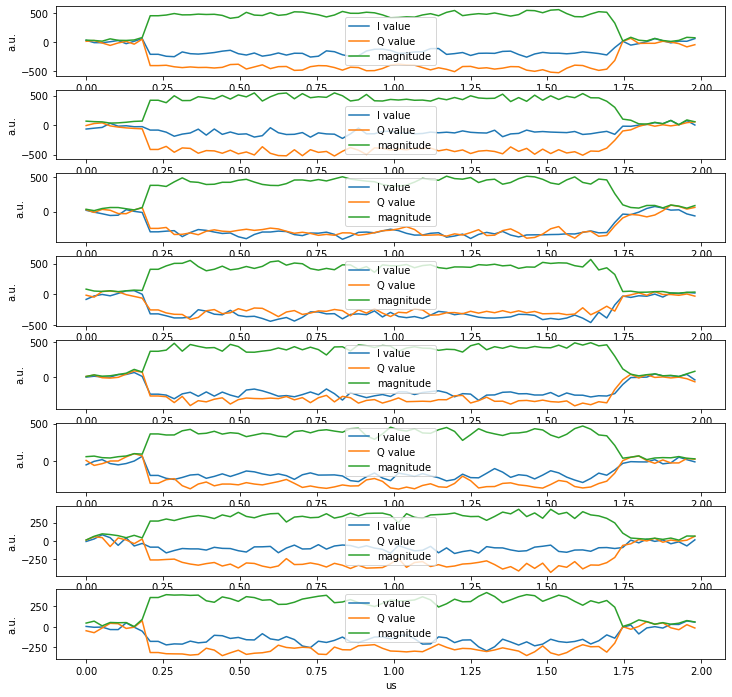

In [32]:
class MuxProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5,6,7],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': GEN_CH_MUX,
          'ro_chs': RO_CHS_MUX,
          'mixer_freq': 6000,
          'nqz': 2,
          'pulse_freqs': 5700+np.arange(8)*50,
          'pulse_gains': [0.25]*8,
          'pulse_phases': [0.0]*8,
          'ro_phases': [0.0]*8,
          'trig_time': 0.5,
          'pulse_len': 1.5,
          'ro_len': 2.0,
          # 'trig_time': 1.0,
          # 'pulse_len': 3.0,
          # 'ro_len': 2.5,
         }

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=1, progress=False)
t = prog.get_time_axis(ro_index=0)

phases = [np.angle(iq.mean(axis=0).dot([1,1j]), deg=True) for iq in iq_list]
print("phase offsets:", phases)
config['pulse_phases'] = [-x for x in phases]

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=10)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

The pulse length and the tone set can be varied dynamically from pulse to pulse.

The tone frequency/amplitude/phase cannot be changed dynamically, and arbitrary envelopes cannot be used - the intended use for the multiplexed generator is readout, not control.

  0%|          | 0/10 [00:00<?, ?it/s]

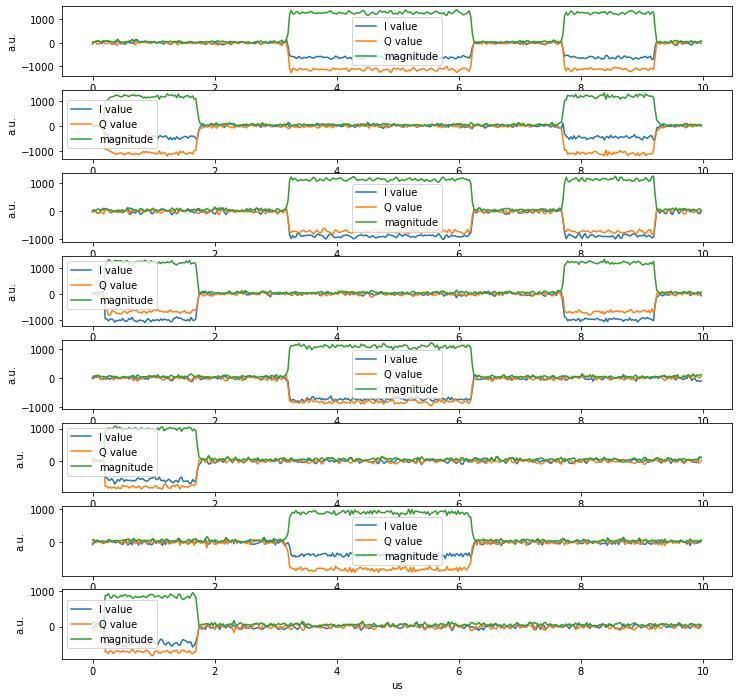

In [33]:
class MuxProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=5*cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux1", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[1,3,5,7],
                      )

        self.add_pulse(ch=gen_ch, name="mymux2", 
                       style="const", 
                       length=2*cfg["pulse_len"],
                       mask=[0,2,4,6],
                      )

        self.add_pulse(ch=gen_ch, name="mymux3", 
                       style="const", 
                       length=1*cfg["pulse_len"],
                       mask=[0,1,2,3],
                      )

    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux1", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mymux2", t=2*cfg["pulse_len"])
        self.pulse(ch=cfg['gen_ch'], name="mymux3", t=5*cfg["pulse_len"])

prog = MuxProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=10)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

### Readout channelizer
The mux readout is based on a polyphase filter bank which divides the spectrum into 64 frequency channels.

We can get a better sense of how this works by taking FFTs of the output from each channel.

PFB Readout Parameters:
 -> fs                = 1228.8 MHz
 -> Channel Distance  = 19.2 MHz
 -> Channel Bandwidth = 38.4 MHz


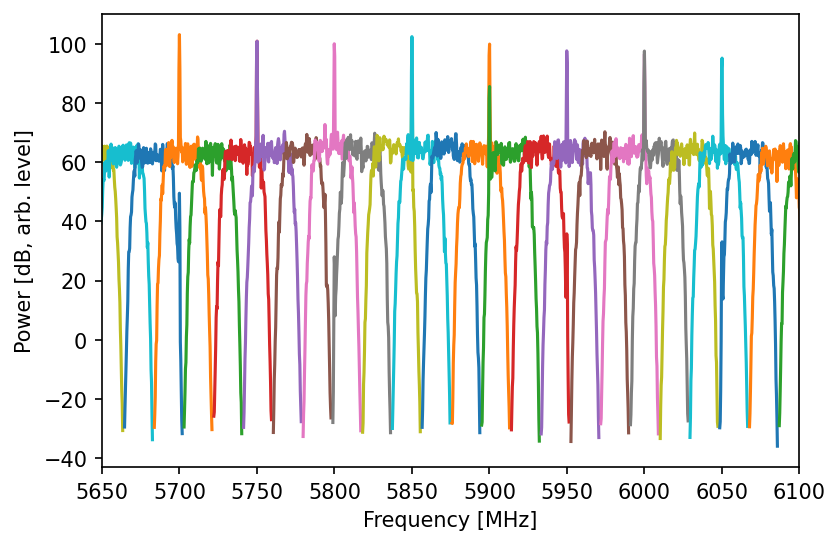

In [34]:
from numpy.fft import fftshift
from scipy.signal import welch

rocfg = soccfg['readouts'][RO_CHS_MUX[0]]
fs = rocfg['fs']/rocfg['decimation'] # total frequency span
N = rocfg['pfb_nch'] # number of PFB channels
M = rocfg['pfb_ch_offset']
fc_ch = fs/N # spacing between channel centers
fs_ch = rocfg['f_dds']
print("PFB Readout Parameters:")
print(" -> fs                = {} MHz".format(fs))
print(" -> Channel Distance  = {} MHz".format(fc_ch))
print(" -> Channel Bandwidth = {} MHz".format(fs_ch))

#################################
### PFB Channels Side-by-Side ###
#################################
class MuxChannelProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']

        freqs = cfg['pulse_freqs']

        # we intentionally don't use frequency matching:
        # we want the RO freqs to be exactly at the channel centers
        # and we don't actually care if the gen freqs are matched
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'],
                         mux_freqs=freqs, 
                         mux_gains=[cfg['pulse_gain']]*len(freqs), 
                         mux_phases=[0.0]*len(freqs),
                         mixer_freq=cfg['mixer_freq'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['ro_freq'], phase=0)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5,6,7],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': GEN_CH_MUX,
          'ro_ch': RO_CHS_MUX[0],
          'nqz': 2,
          'mixer_freq': 6000,
          'pulse_freqs': 5700+np.arange(8)*50,
          'pulse_gain': 0.1,
          'trig_time': 1.0,
          'pulse_len': 26.0,
          'ro_len': 25.5,
         }

# Frequency and amplitude vectors.
complex_iq = []
# Loop over channel centers.
foffset = 0*fs_ch/4
fc_v = np.arange(0, fs, fc_ch) + foffset + rocfg['fs']*2
for fck in fc_v:
    # Update frequency.
    config['ro_freq'] = fck
    
    # Get data from channel.
    prog = MuxChannelProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
    
    iq_list = prog.acquire_decimated(soc, progress=False)
    complex_iq.append(iq_list[0].dot([1,1j]))
    
fig, ax = plt.subplots(1, dpi=150);
for fck, x in zip(fc_v, complex_iq):
    fft_freqs, psd = fftshift(welch(x, fs_ch, return_onesided=False, nperseg=128, detrend=False), axes=1)
    # we drop the FFT points at the ends of the range
    ax.plot(fft_freqs[2:-1]+fck, 20*np.log10(psd[2:-1]))

ax.set_xlabel("Frequency [MHz]");
ax.set_ylabel("Power [dB, arb. level]");   
ax.set_xlim(5650,6100);

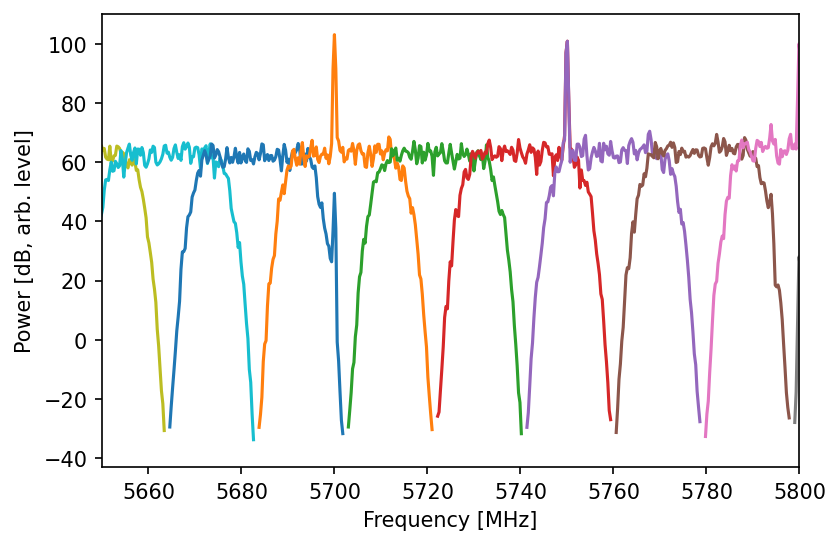

In [35]:
ax.set_xlim(5650,5800)
fig

### extra: measuring power, checking for saturation

In [36]:
class PeriodicProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                       mode='periodic',
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)


def measure_gain(soc, soccfg, gain, dac_att1, dac_att2, adc_att):
    config = {'gen_ch': GEN_CH_RF,
          'ro_ch': RO_CH_RF,
          'mixer_freq': 6000,
          'freq': 6000,
          'nqz': 2,
          'trig_time': 0.0,
          'ro_len': 10.0,
          'flat_len': 1.0,
          'phase': 0,
          'gain': gain
         }
    soc.rfb_set_dac_rf(DAC_RF, dac_att1, dac_att2)
    soc.rfb_set_adc_rf(ADC_RF, adc_att)
    prog = PeriodicProgram(soccfg, reps=1000, final_delay=0.5, cfg=config)
    soc.rfb_set_dac_rf(DAC_RF, dac_att1, dac_att2)
    soc.rfb_set_adc_rf(ADC_RF, adc_att)
    amp = prog.acquire(soc, progress=False)[0][0].dot([1, 1j])
    soc.reset_gens()
    soc.clear_interrupts()
    mag = np.abs(amp)
    return mag


In [37]:
# ref_mag = measure_gain(soc, soccfg, 0.5, DAC_ATT[0], DAC_ATT[1], ADC_ATT)
# print("default amplitude: %f" % (ref_mag))

# mag = measure_gain(soc, soccfg, 0.5*10**(0.15), DAC_ATT[0], DAC_ATT[1], ADC_ATT)
# boost = 20*np.log10(mag/ref_mag)
# print("with +3 dB gain: amplitude %f, a %f dB increase" % (mag, boost))

# mag = measure_gain(soc, soccfg, 0.5, DAC_ATT[0], DAC_ATT[1]-3, ADC_ATT)
# boost = 20*np.log10(mag/ref_mag)
# print("with -3 dB DAC att2: amplitude %f, a %f dB increase" % (mag, boost))

# mag = measure_gain(soc, soccfg, 0.5, DAC_ATT[0], DAC_ATT[1], ADC_ATT-3)
# boost = 20*np.log10(mag/ref_mag)
# print("with -3 dB ADC att: amplitude %f, a %f dB increase" % (mag, boost))


In [38]:
# config = {'gen_ch': GEN_CH_BALUN,
#       'ro_ch': RO_CH_BALUN,
#       'mixer_freq': 6000,
#       'freq': 6000,
#       'nqz': 2,
#       'trig_time': 0.0,
#       'ro_len': 10.0,
#       'flat_len': 1.0,
#       'phase': 0,
#       'gain': 0.5
#      }
# prog = PeriodicProgram(soccfg, reps=1000, final_delay=0.5, cfg=config)
# amp = prog.acquire(soc, progress=False)[0][0].dot([1, 1j])
# print(np.abs(amp))
# # -29 dBm

In [39]:
# config = {'gen_ch': GEN_CH_RF,
#       'ro_ch': RO_CH_RF,
#       'mixer_freq': 6000,
#       'freq': 6000,
#       'nqz': 2,
#       'trig_time': 0.0,
#       'ro_len': 10.0,
#       'flat_len': 1.0,
#       'phase': 0,
#       'gain': 0.5
#      }
# soc.reset_gens()
# prog = PeriodicProgram(soccfg, reps=1000, final_delay=0.5, cfg=config)
# soc.rfb_set_dac_rf(DAC_RF, 0, 22)
# soc.rfb_set_adc_rf(ADC_RF, 25)
# soc.rfb_set_dac_filter(DAC_RF, fc=config['freq']/1000, ftype='bandpass', bw=1.0)
# soc.rfb_set_adc_filter(ADC_RF, fc=config['freq']/1000, ftype='bandpass', bw=1.0)

# amp = prog.acquire(soc, progress=False)[0][0].dot([1, 1j])
# print(np.abs(amp))
# # -29 dBm